# Assignment 3: Text processing with LSTM in PyTorch

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

In this assignment you will a train an LSTM to generate text. To be able to feed text into (recurrent) neural networks we first have to choose a good representation. There are several options to do so ranging from simple character embeddings to more sophisticated approaches like [word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) or [token embeddings](https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a). We will use a character embedding in this assignment. 

Character embeddings work as follows. First we define an alphabet, a set of characters that we want to be able to represent. To feed a character into our network we use a one-hot vector. The dimension of this vector is equal to the size of our alphabet and the "hot" position indicates the character we want to represent. While this is logically a decent representation (all characters have the same norm, are orthogonal to one another, etc.) it is inefficient in terms of memory because we have to store a lot of zeros. In the first layer of our network we will multiply our one-hot vector with a weight matrix, i.e. we compute the preactivation by a matrix-vector product of the form $We_i$, where $e_i$ is the $i$-th canonical basis vector. This operation corresponds to selecting the $i$-th column of $W$. So an efficient implementation is to perform a simple lookup operation in $W$. This is how embedding layers work also for word or token embeddings. They are learnable lookup tables. 

## Exercise 1: Encoding characters

Write a class `Encoder` that implements the methods `__init__` and `__call__`. The method `__init__` takes a string as argument that serves as alphabet. The method `__call__` takes one argument. If it is a string then it should return a sequence of integers as `torch.Tensor` of shape  representing the input string. Each integer should represents a character of the alphabet. The alphabet consists of the characters matched by the regex `[a-z0-9 .!?]`. If the input text contains characters that are not in the alphabet, then `__call__` should either remove them or map them to a corresponding character that belongs to the alphabet. If the argument is a `torch.Tensor`, then the method should return a string representation of the input, i.e. it should function as decoder. 

In [1]:
import re
import torch

########## YOUR SOLUTION HERE ##########

class Encoder:
    
    def __init__(self, alphabet):
        self.alphabet = alphabet
        self.alphabet_dict = dict([(alphabet[i],i) for i in range(len(alphabet))])
        regex_alphabet = "[a-z0-9 .!?]"
        self.regex_pattern = re.compile(regex_alphabet)
        
    def __call__(self, x):
        # encoder
        if type(x) is str:
            matched = self.regex_pattern.findall(x.lower())
            integers = [self.alphabet_dict[char] for char in matched]
            return torch.LongTensor(integers)
        # decoder
        elif type(x) is torch.Tensor:
            return "".join([self.alphabet[idx] for idx in x])
        # just in case
        else:
            raise TypeError("Invalid input data type!")

query = "hello,#. I am Choral ! )"
alphabet_candidate = "abcdefghijklmnopqrstuvwxyz0123456789 .!?"
enc = Encoder(alphabet_candidate)
tensor = enc(query)


## Exercise 2: Pytorch Dataset

Write a class `TextDataset` that derives from `torch.utlis.data.Dataset`. It should wrap a text file and utilize it for training with pytorch. Implement the methods `__init__`, `__len__`, `__getitem__`. The method `__init__` should take a path to a text file as string and an integer `l` specifying the length of one sample sequence. The method `__len__` takes no arguments and should return the size of the dataset, i.e. the number of sample sequences in the dataset. The method `__getitem__` should take an integer indexing a sample sequence and should return that sequence as a `torch.Tensor`. The input file can be viewed as one long sequence. The first sample sequence consists of the characters at positions `0..l-1` in the input file. The second sequence consists of the characters at positions `l..2*l-1` and so on. That is, the samples of our dataset are non-overlapping sequences. The last incomplete sequence may be dropped. 

In [2]:
import torch
from torch.utils.data import Dataset

########## YOUR SOLUTION HERE ##########

class TextDataset(Dataset):
    
    def __init__(self, file_path, l, as_int=False):
        super().__init__()
        
        self.as_int = as_int
        
        # load text file
        file = open(file_path, 'r')
        self.content = file.read()
        file.close()
        
        # generate samples
        def make_samples(string, length):
            return [string[i:i + length] 
                    for i in range(0, len(string), length)]
        
        if as_int:
            encoded_content = enc(self.content)
            self.samples = make_samples(encoded_content, l)
            # drop last sample if the sequence is too short
            if len(self.samples[-1]) != l:
                self.samples = self.samples[:-1]

        else:
            self.samples = make_samples(self.content, l)
            # drop last sample if the sequence is too short
            if len(self.samples[-1]) != l:
                self.samples = self.samples[:-1]
                        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx:int):
        return self.samples[idx]
    

path = "trump_texts/trump_train.txt"
sample_length = 25
dataset = TextDataset(path, sample_length, as_int=True)

## Exercise 3: The Model

Write a class `NextCharLSTM` that derives from `torch.nn.Module` and takes `alphabet_size`, the `embedding_dim`, and the `hidden_dim` as arguments. It should consist of a `torch.nn.Embedding` layer that maps the alphabet to embeddings, a `torch.nn.LSTM` that takes the embeddings as inputs and maps them to hidden states, and a `torch.nn.Linear` output layer that maps the hidden states of the LSTM back to the alphabet. Implement the methods `__init__` that sets up the module and `forward` that takes an input sequence and returns the logits (i.e. no activation function on the output layer) of the model prediction at every time step. 

In [3]:
import torch.nn as nn
import torch.nn.functional as F

########## YOUR SOLUTION HERE ##########

class NextCharLSTM(torch.nn.Module):
    
    def __init__(self, alphabet_size, embedding_dim, hidden_dim):
        
        super().__init__()
        self.alphabet_size = alphabet_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # embedding
        self.embedding = torch.nn.Embedding(alphabet_size, embedding_dim)
        # lstm layer
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # linear layer
        self.linear = torch.nn.Linear(hidden_dim, alphabet_size)
    
    def forward(self, sequence):
        
        char_embeddings = self.embedding(sequence)
        out, _ = self.lstm(char_embeddings)
        pred = self.linear(out)
        
        return pred
    
model = NextCharLSTM(len(enc.alphabet_dict),20,30)
x = dataset[0]
out = model(x[None,:])

#print(out.shape)

## Exercise 4: Training/Validation Epoch

Write a function `epoch` that takes a `torch.utils.data.DataLoader`, a `NextCharLSTM`, and a `torch.optim.Optimizer` as arguments, where the last one might be `None`. If the optimizer is `None`, then the function should validate the model. Otherwise it should train the model for next-character prediction in the many-to-many setting. That is, given a sequence `x` of length `l`, the input sequence is `x[:l-1]` and the corresponding target sequence is `x[1:]`. The function should perform one epoch of training/validation and return the loss values of each mini batch as a numpy array. Use the cross-entropy loss function for both training and validation. 

In [4]:
from torch.utils.data import DataLoader
import numpy as np

########## YOUR SOLUTION HERE ##########
from torch.optim import Optimizer
from torch.optim import Adam
from torch.nn import CrossEntropyLoss as CEL

loss_f = CEL()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def train(dataloader:DataLoader, model:NextCharLSTM, optimizer:Optimizer):
    
    losses = []
    for batch in dataloader:

        X = batch[:, :-1].to(device)
        y = batch[:, 1:].to(device)
        
        optimizer.zero_grad()

        logits = model(X)
        
        _,_,alphabet_size = logits.shape
        
        
        l = loss_f(torch.transpose(logits.squeeze(), -1, -2),y)

        l.backward()
        optimizer.step()
        
        losses.append(l.cpu().detach())

    return np.array(losses)

def validate(dataloader:DataLoader, model:NextCharLSTM):
    
    with torch.no_grad():
        losses = []
        for batch in dataloader:

            X = batch[:,:-1].to(device)
            y = batch[:,1:].to(device)

            logits = model(X)
            #preds = F.softmax(logits, dim=-1)
            preds = logits
            _,_,alphabet_size = logits.shape

            l = loss_f(torch.transpose(logits.squeeze(), -1, -2),y)
            losses.append(l.cpu())
        
    return np.array(losses)

def epoch(dataloader:DataLoader, model:NextCharLSTM, optimizer:Optimizer=None):
    
    if optimizer is None:
        return validate(dataloader, model)     
    else:
        return train(dataloader, model, optimizer)
        

#path = "trump_texts/trump_train.txt"
#sample_length = 100
#train_dataset = TextDataset(path, sample_length, as_int=True)
#train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#model = NextCharLSTM(len(enc.alphabet_dict),8,100).to(device)
#print(epoch(train_loader, model, Adam(model.parameters())))
#epoch(train_loader, model)

## Exercise 5: Model Selection

Usually, we would now train and validate our model on a grid of with different hyperparameters to see which setting performs best. However, this is pretty expensive in terms of compute so we will provide you with a setting that should work quite well. Train your model for 30 epochs using `torch.optim.Adam`. Validate your model after every epoch and persist the model that performs best on the validation set using `torch.save`. Visualize and discuss the training and validation progress. 

In [5]:
import matplotlib.pyplot as plt

sequence_length = 100 
batch_size = 256 
embedding_dim = 8 # ori=8
hidden_dim = 512
learning_rate = 1e-3

########## YOUR SOLUTION HERE ##########

torch.manual_seed(1)
n_epochs = 100

# training dataset
path = "trump_texts/trump_train.txt"
train_dataset = TextDataset(path, sequence_length, as_int=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# validation dataset
path = "trump_texts/trump_val.txt"
valid_dataset = TextDataset(path, sequence_length, as_int=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# initialize model and optimizer
model = NextCharLSTM(len(enc.alphabet_dict), embedding_dim, hidden_dim).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

# for validation
best_loss = 10000
best_model = model

train_epoch_losses = []
valid_epoch_losses = []
for n in range(1, n_epochs+1):
    
    epoch_loss_train = np.mean(epoch(train_loader, model, optimizer))
    epoch_loss_valid = np.mean(epoch(valid_loader, model))
    
    if epoch_loss_valid < best_loss:
        best_loss = epoch_loss_valid
        best_model = model
        torch.save(model, 'best_model.pt')
        
    if n % 5 == 0:
        print(f"Epoch: {n}")
        print("Mean epoch training loss:",epoch_loss_train)
        print("Mean epoch validation loss:",epoch_loss_valid)
        print()
    
    train_epoch_losses.append(epoch_loss_train)
    valid_epoch_losses.append(epoch_loss_valid)

Epoch: 5
Mean epoch training loss: 2.2947807
Mean epoch validation loss: 2.3144143

Epoch: 10
Mean epoch training loss: 1.7970397
Mean epoch validation loss: 1.892355

Epoch: 15
Mean epoch training loss: 1.5544711
Mean epoch validation loss: 1.6824888

Epoch: 20
Mean epoch training loss: 1.4116397
Mean epoch validation loss: 1.5552466

Epoch: 25
Mean epoch training loss: 1.3164766
Mean epoch validation loss: 1.4761142

Epoch: 30
Mean epoch training loss: 1.2465684
Mean epoch validation loss: 1.420415

Epoch: 35
Mean epoch training loss: 1.191083
Mean epoch validation loss: 1.3848976

Epoch: 40
Mean epoch training loss: 1.1455594
Mean epoch validation loss: 1.353829

Epoch: 45
Mean epoch training loss: 1.1058674
Mean epoch validation loss: 1.3359687

Epoch: 50
Mean epoch training loss: 1.0692503
Mean epoch validation loss: 1.3224021

Epoch: 55
Mean epoch training loss: 1.0350473
Mean epoch validation loss: 1.3122798

Epoch: 60
Mean epoch training loss: 1.0042531
Mean epoch validation lo

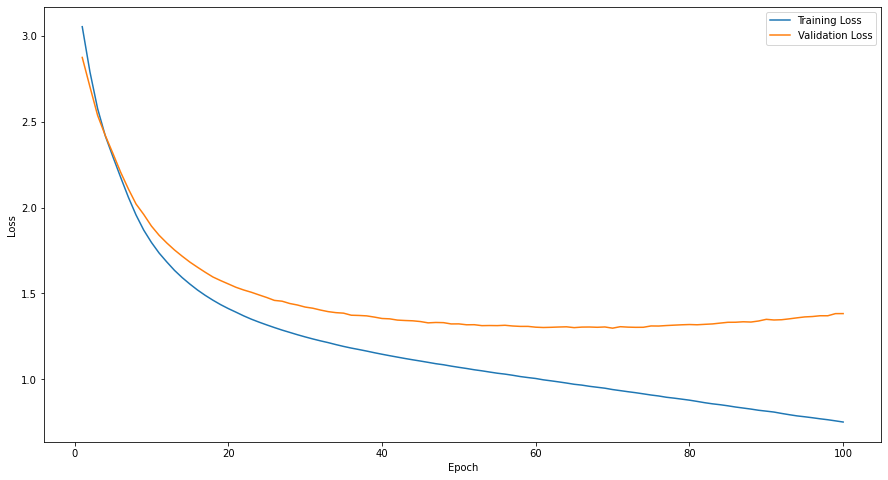

In [6]:
# Visualize
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,n_epochs+1), train_epoch_losses)
plt.plot(np.arange(1,n_epochs+1), valid_epoch_losses)

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend(["Training Loss", "Validation Loss"])

plt.show()


## Exercise 6: Top-$k$ Accuracy

Write a function `topk_accuracy` that takes a list of integers $k$, a model, and a data loader and returns the top-$k$ accuracy of the model on the given data set for each $k$. A sample is considered to be classified correctly if the true label appears in the top-$k$ classes predicted by the model. Then load the best model from the previous exercise using `torch.load` and plot its top-$k$ accuracy as a function of $k$ for all possible values of $k$. Discuss the results. 

In [7]:
########## YOUR SOLUTION HERE ##########

def topk_accuracy(k_list, model, dataloader, only_last=True):
        
    with torch.no_grad():
        
        probs = []
        for batch in dataloader:

            X = batch[:,:-1].to(device)
            y = batch[:,1:].to(device)

            logits = model(X)

            _,_,alphabet_size = logits.shape
            
            top_k_logits, top_k_indices = torch.topk(logits, np.max(k_list), dim=-1)
            #print(top_k_indices)
            for k in k_list:
                
                N = 0
                C = 0
                for b in range(len(y)):
                    C += torch.sum(top_k_indices[b,:,:k].T == y[b])
                    N += len(y[b])
                probs.append((C/N).cpu())
                
    return probs

best_model = torch.load("best_model.pt")

path = "trump_texts/trump_val.txt"
test_dataset = TextDataset(path, sequence_length, as_int=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

k_list = list(range(2,40+1))

probs = topk_accuracy(k_list, best_model, test_loader)

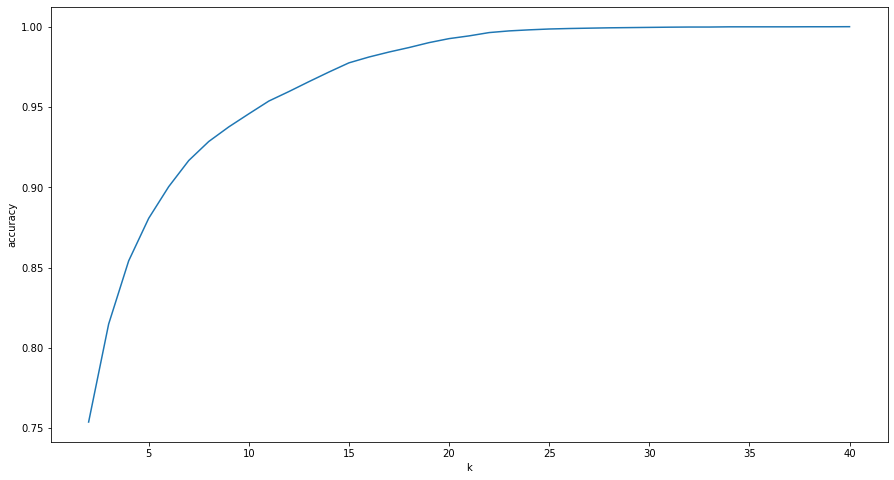

In [8]:
plt.figure(figsize=(15,8))
plt.plot(k_list, probs)
plt.ylabel("accuracy")
plt.xlabel("k")
plt.show()

## Exercise 7: Gumbel-Max Character Sampling

In this exercise we utilize the trained network to generate novel text. To do this, take some string of seed text, which you can choose freely, and feed it to the network. For each subsequent character, the model outputs logits $z = (z_1, \dots, z_K)^\top$, where $K$ is the alphabet size. 

Use the Gumbel-Max trick to sample from the categorical distribution parameterized by 
$$
\pi_k = \frac{e^{z_k / \tau}}{\sum_{j=1}^K e^{z_j / \tau}} \quad \text{where} \quad \tau > 0 
$$
is the temperature. For $\tau \to 0$ we approach the one-hot distribution, whereas for $\tau \to \infty$ we approach the uniform distribution. The Gumbel-Max trick says that the random variable 
$$
Y = \arg \max_{k \in 1, \dots, K} (z_k / \tau + \xi_k) 
$$
follows a categorical distribution parameterized by $\pi_1, \dots, \pi_K$, where $\xi_k$ is drawn independently from the standard Gumbel distribution.

Implement next-character sampling using the Gumbel-Max trick. Try out different values of $\tau$ and see which work best. 

In [9]:
########## YOUR SOLUTION HERE ##########
best_model = torch.load("best_model.pt").cpu()

integers = np.arange(40)

for tau in [0.0001,0.01, 0.1, 0.25, 0.5 ,0.75, 1, 2, 5, 25, 150]:
    print(tau)
    seed_text = "Thank you all for supporting me! Together we can make Ameri"
    init_seed = seed_text
    addition = ""
    for i in range(50):
        seed_ints = enc(seed_text)[None,:]

        out = best_model(seed_ints)[-1]

        gumbel = F.gumbel_softmax(out, tau=tau)[-1]

        sampled_next_int = np.random.choice(integers, p=gumbel.detach().numpy())
        next_char = alphabet_candidate[int(sampled_next_int)]
        seed_text += next_char
        addition += next_char
    
    print("".join([init_seed,"|", addition]))
    print()

0.0001
Thank you all for supporting me! Together we can make Ameri|ca.we had a big groups go in in.ane i year it righ

0.01
Thank you all for supporting me! Together we can make Ameri|ca great again what she doesnt win with our eriopl

0.1
Thank you all for supporting me! Together we can make Ameri|ca great again this is what you do? what were out 

0.25
Thank you all for supporting me! Together we can make Ameri|ca great.and lasten hearity to invbyint to dam and

0.5
Thank you all for supporting me! Together we can make Ameri|ca great agroment of hostoups outs daslity one for

0.75
Thank you all for supporting me! Together we can make Ameri|ca safe. but we could not dep were talking abeit d

1
Thank you all for supporting me! Together we can make Ameri|cas watted with speech zerw will be sive friend pe

2
Thank you all for supporting me! Together we can make Ameri|ca nvendu afrued tysug todoy on a vectrnmphouifany

5
Thank you all for supporting me! Together we can make Ameri|n!c1g8yr

## Exercise 8: Huffman Coding using LSTM

*Thanks to Philipp Renz who had this idea.*

The Huffman code is an algorithm to compress data. It encodes symbols with different lengths depending on their frequencies. It assigns a short code to frequent symbols and a longer code to rare symbols to minimize the average code length. We provide you with an implementation that given a list of frequencies `freqs` returns a list of their respective binary codes as strings in the same order. In fact, `freqs` may contain any real numbers. 

With a model that predicts the next symbol we can achieve even shorter codes. At every time step we can use the predicted probabilities as frequencies for the Huffman code. That is, we use a new code at every time step. This code is governed by the model's belief what the next symbol will be. If the model predictions are good, we will mostly use very short codes.

First, determine the average code length per symbol on the validation set using frequencies determined on the training set. 
Then, use the prediction probabilities of your trained LSTM and determine the average code length per symbol on the validation set using an adaptable code. Add a temperature to the softmax and tune it. How many bits per symbol can you save by using the LSTM and what is the optimal temperature? 

In [10]:
from heapq import heapify, heappop, heappush

def huffman_code(freqs):
    """This function turns a list of frequencies into a Huffman code. """
    heap = list(zip(freqs, [(i,) for i in range(len(freqs))]))
    heapify(heap)
    code = [''] * len(freqs)
    
    while len(heap) > 1:
        freq0, idx0 = heappop(heap)
        freq1, idx1 = heappop(heap)
        heappush(heap, (freq0 + freq1, idx0 + idx1))
        
        for i in idx0:
            code[i] = '0' + code[i]
        
        for i in idx1:
            code[i] = '1' + code[i]
    
    return code

########## YOUR SOLUTION HERE ##########

# load training text file
train_path = "trump_texts/trump_train.txt"
train_file = open(train_path, 'r')
train_text = train_file.read()
train_file.close()

# load validation text file
val_path = "trump_texts/trump_val.txt"
val_file = open(val_path, 'r')
val_text = val_file.read()
val_file.close()

train_frequencies = torch.bincount(enc(train_text))
train_huffman = huffman_code(train_frequencies)
train_huffman_dict = dict(zip(integers,train_huffman))

val_mean_length = np.mean([len(train_huffman_dict[int(idx)]) for idx in enc(val_text)])
print(f"Mean validation code length with values determined on training set:", val_mean_length)

Mean validation code length with values determined on training set: 4.222500323652526


In [11]:
model = torch.load("best_model.pt").cpu()
val_tensor = enc(val_text)
out = model(val_tensor[None,:])[:,:5000]

In [12]:
for tau in [0.0001,0.01, 0.1, 0.25, 0.5 ,0.75, 1, 2, 5, 25, 150]:
    code_lengths = []
    for i in range(out.shape[1]):
        logits = out[:,i]
        preds = F.softmax(logits/tau, dim=-1)[0]
        code = huffman_code(preds)

        next_char = val_tensor[i+1].int()

        code_lengths.append(len(code[next_char]))
    print(f"Tau:{tau} -> avg code length:{np.mean(code_lengths)}")

Tau:0.0001 -> avg code length:11.7838
Tau:0.01 -> avg code length:9.163
Tau:0.1 -> avg code length:3.0138
Tau:0.25 -> avg code length:2.8856
Tau:0.5 -> avg code length:2.6218
Tau:0.75 -> avg code length:2.4532
Tau:1 -> avg code length:2.3592
Tau:2 -> avg code length:2.396
Tau:5 -> avg code length:3.4616
Tau:25 -> avg code length:4.9942
Tau:150 -> avg code length:5.0038


We can save approx. 1.9 bits per symbol if we use tau=1!!